In [18]:
pip install pygame


Defaulting to user installation because normal site-packages is not writeable
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.0/14.0 MB 95.8 MB/s eta 0:00:00:00:010:01

[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [12]:
import gym
import numpy as np
import random
from collections import deque
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt


In [13]:
class DQN(nn.Module):
    def __init__(self, input_dim, action_size):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, action_size)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)


In [14]:
class ReplayMemory:
    def __init__(self, capacity=10000):
        self.capacity = capacity
        self.memory = deque(maxlen=capacity)

    def push(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)


In [15]:
class DQNAgent:
    def __init__(self, input_dim, action_size, lr=1e-3):
        self.input_dim = input_dim
        self.action_size = action_size
        self.gamma = 0.99
        self.epsilon = 1.0
        self.epsilon_min = 0.01
        self.epsilon_decay = 1e-3
        self.batch_size = 64
        self.memory = ReplayMemory(10000)
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        # Initialize networks
        self.policy_net = DQN(input_dim, action_size).to(self.device)
        self.target_net = DQN(input_dim, action_size).to(self.device)
        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=lr)

        self.update_target_net()

    def update_target_net(self):
        self.target_net.load_state_dict(self.policy_net.state_dict())

    def get_action(self, state):
        if np.random.rand() <= self.epsilon:
            return np.random.randint(self.action_size)
        state = torch.FloatTensor(state).unsqueeze(0).to(self.device)
        with torch.no_grad():
            return self.policy_net(state).argmax(1).item()

    def train(self):
        if len(self.memory) < self.batch_size:
            return
        minibatch = self.memory.sample(self.batch_size)
        states, actions, rewards, next_states, dones = zip(*minibatch)

        states = torch.FloatTensor(states).to(self.device)
        actions = torch.LongTensor(actions).unsqueeze(1).to(self.device)
        rewards = torch.FloatTensor(rewards).to(self.device)
        next_states = torch.FloatTensor(next_states).to(self.device)
        dones = torch.FloatTensor(dones).to(self.device)

        q_values = self.policy_net(states).gather(1, actions)
        max_next_q_values = self.target_net(next_states).max(1)[0].detach()
        expected_q_values = rewards + (1 - dones) * self.gamma * max_next_q_values

        loss = F.mse_loss(q_values.squeeze(), expected_q_values)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        if self.epsilon > self.epsilon_min:
            self.epsilon -= self.epsilon_decay


In [16]:
env = gym.make('CartPole-v1')
input_dim = env.observation_space.shape[0]
action_size = env.action_space.n

agent = DQNAgent(input_dim, action_size)
num_episodes = 1000
target_update_freq = 10
rewards_per_episode = []

for e in range(num_episodes):
    state = env.reset()
    total_reward = 0
    done = False

    while not done:
        action = agent.get_action(state)
        next_state, reward, done, _ = env.step(action)
        agent.memory.push(state, action, reward, next_state, done)
        state = next_state
        total_reward += reward

        agent.train()

    rewards_per_episode.append(total_reward)
    if e % target_update_freq == 0:
        agent.update_target_net()

    print(f"Episode: {e}, Total Reward: {total_reward}, Epsilon: {agent.epsilon:.4f}")

env.close()


Episode: 0, Total Reward: 38.0, Epsilon: 1.0000
Episode: 1, Total Reward: 27.0, Epsilon: 0.9980
Episode: 2, Total Reward: 13.0, Epsilon: 0.9850
Episode: 3, Total Reward: 42.0, Epsilon: 0.9430
Episode: 4, Total Reward: 10.0, Epsilon: 0.9330
Episode: 5, Total Reward: 15.0, Epsilon: 0.9180
Episode: 6, Total Reward: 15.0, Epsilon: 0.9030
Episode: 7, Total Reward: 15.0, Epsilon: 0.8880
Episode: 8, Total Reward: 11.0, Epsilon: 0.8770
Episode: 9, Total Reward: 19.0, Epsilon: 0.8580
Episode: 10, Total Reward: 17.0, Epsilon: 0.8410
Episode: 11, Total Reward: 12.0, Epsilon: 0.8290
Episode: 12, Total Reward: 47.0, Epsilon: 0.7820
Episode: 13, Total Reward: 17.0, Epsilon: 0.7650
Episode: 14, Total Reward: 21.0, Epsilon: 0.7440
Episode: 15, Total Reward: 14.0, Epsilon: 0.7300
Episode: 16, Total Reward: 14.0, Epsilon: 0.7160
Episode: 17, Total Reward: 19.0, Epsilon: 0.6970
Episode: 18, Total Reward: 25.0, Epsilon: 0.6720
Episode: 19, Total Reward: 38.0, Epsilon: 0.6340
Episode: 20, Total Reward: 25.

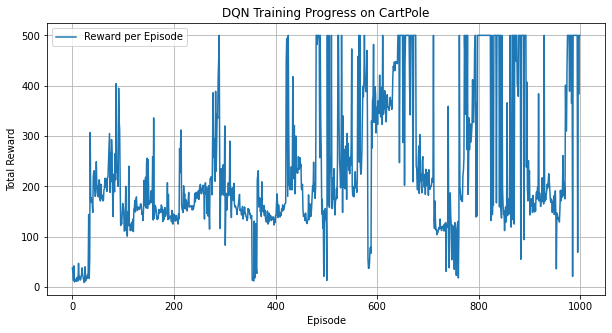

In [17]:
plt.figure(figsize=(10, 5))
plt.plot(rewards_per_episode, label='Reward per Episode')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('DQN Training Progress on CartPole')
plt.legend()
plt.grid()
plt.show()


In [18]:
def evaluate_agent(agent, env, num_episodes=5):
    for e in range(num_episodes):
        state, _ = env.reset()  # Ensure correct unpacking
        total_reward = 0
        done = False
        print(f"Starting Episode {e}...")
        
        while not done:
            # Render the environment (optional, requires pygame)
            env.render()
            
            # Get the action from the agent
            action = agent.get_action(state)
            
            # Step through the environment
            next_state, reward, done, _, = env.step(action)
            
            # Accumulate rewards
            total_reward += reward
            
            # Update the current state
            state = next_state
        
        print(f"Evaluation Episode: {e}, Total Reward: {total_reward}")
    env.close()
